In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
images = '../Project Code/Original Images'

img_width, img_height = 224, 224  # Default input size for VGG16

batch_size=12

In [3]:
# Instantiate convolutional base

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

In [5]:
train_generator = datagen.flow_from_directory(images,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

Found 304 images belonging to 3 classes.


In [6]:
validation_generator = datagen.flow_from_directory(images,
                                                         target_size=(img_height, img_width),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 76 images belonging to 3 classes.


In [7]:
# Extract features from the train generator using VGG16
train_features = np.zeros(shape=(304, 7, 7, 512))
train_labels = np.zeros(shape=(304, 3))

# Pass through pre-trained convolution base
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = conv_base.predict(inputs_batch)
    train_features[i * batch_size: (i+1) * batch_size] = features_batch
    train_labels[i * batch_size: (i+1) * batch_size] = labels_batch
    i += 1
    if i*batch_size >= 304:
        break

In [9]:
print(train_features.shape)
print(train_labels.shape)

(304, 7, 7, 512)
(304, 3)


In [10]:
# Extract features from validation generator using VGG16
val_features = np.zeros(shape=(76, 7, 7, 512))
val_labels = np.zeros(shape=(76, 3))

# Pass through pre-trained convolution base
i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = conv_base.predict(inputs_batch)
    val_features[i * batch_size: (i+1) * batch_size] = features_batch
    val_labels[i * batch_size: (i+1) * batch_size] = labels_batch
    i += 1
    if i*batch_size >= 76:
        break

In [11]:
print(val_features.shape)
print(val_labels.shape)

(76, 7, 7, 512)
(76, 3)


In [12]:
#Flattening the features extraction to train the DT as it expects array of <= 2 dimensions
train_features_flatten = train_features.reshape((train_features.shape[0], 7 * 7 * 512))
val_features_flatten = val_features.reshape((val_features.shape[0], 7 * 7 * 512))

In [13]:
dt = DecisionTreeClassifier(random_state=42)

In [14]:
dt.fit(train_features_flatten, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

train_labels_pred = dt.predict(train_features_flatten)
print("\nAccuracy on Training Data: ", accuracy_score(train_labels, train_labels_pred))
print("\n\nClassification Matrix on Training Data:\n\n",classification_report(train_labels, train_labels_pred))

val_labels_pred = dt.predict(val_features_flatten)
print("\nAccuracy on Testing Data: ", accuracy_score(val_labels, val_labels_pred))
print("\n\nClassification Matrix on Testing Data:\n\n",classification_report(val_labels, val_labels_pred))

In [15]:
#Initializing gridsearch1 for DT to find the optimum parameters

dt_GS = GridSearchCV(dt, param_grid={"max_leaf_nodes":[10,20,30,50,70,90,100,110,115]}, cv=5)

In [16]:
dt_GS.fit(train_features_flatten, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [10, 20, 30, 50, 70, 90, 100, 110,
  

In [17]:
results = pd.DataFrame(dt_GS.cv_results_)

In [19]:
print("Best parameters of Grid Search 1: ", dt_GS.best_params_,'\n\n')
print(results[['param_max_leaf_nodes','mean_test_score','rank_test_score']])

Best parameters of Grid Search 1:  {'max_leaf_nodes': 20} 


  param_max_leaf_nodes  mean_test_score  rank_test_score
0                   10         0.848689                9
1                   20         0.851967                1
2                   30         0.851967                1
3                   50         0.851967                1
4                   70         0.851967                1
5                   90         0.851967                1
6                  100         0.851967                1
7                  110         0.851967                1
8                  115         0.851967                1


In [20]:
max_leaf_nodes=([10,20,30,50,70,90,100,110,115])

In [21]:
acc_score_train = []
acc_score_val = []

In [22]:
for item in max_leaf_nodes:
    dt_prune = DecisionTreeClassifier(max_leaf_nodes = item, random_state = 42)
    dt_prune.fit(train_features_flatten, train_labels)
    train_labels_pred_prune = dt_prune.predict(train_features_flatten)
    acc_score_train.append(accuracy_score(train_labels, train_labels_pred_prune))
    val_labels_pred_prune = dt_prune.predict(val_features_flatten)
    acc_score_val.append(accuracy_score(val_labels, val_labels_pred_prune))
print(acc_score_train,'\n',acc_score_val)

[0.9736842105263158, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
 [0.7236842105263158, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737]


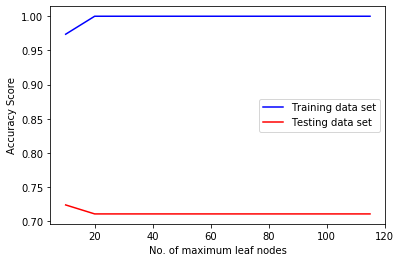

In [23]:
plt.plot(max_leaf_nodes,acc_score_train,'b-',max_leaf_nodes,acc_score_val,'r-')
plt.xlabel('No. of maximum leaf nodes')
plt.ylabel('Accuracy Score')
plt.legend(("Training data set","Testing data set",))
plt.show()

In [24]:
max_leaf_nodes1=([None,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])
acc_score_train1 = []
acc_score_val1 = []
for item in max_leaf_nodes1:
    dt_prune = DecisionTreeClassifier(max_leaf_nodes = item, random_state = 42)
    dt_prune.fit(train_features_flatten, train_labels)
    train_labels_pred_prune = dt_prune.predict(train_features_flatten)
    acc_score_train1.append(accuracy_score(train_labels, train_labels_pred_prune))
    val_labels_pred_prune = dt_prune.predict(val_features_flatten)
    acc_score_val1.append(accuracy_score(val_labels, val_labels_pred_prune))
print(acc_score_train1,'\n',acc_score_val1)

[1.0, 0.2236842105263158, 0.8914473684210527, 0.9342105263157895, 0.9572368421052632, 0.9736842105263158, 0.9802631578947368, 0.9868421052631579, 0.993421052631579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
 [0.6973684210526315, 0.21052631578947367, 0.7368421052631579, 0.7236842105263158, 0.7368421052631579, 0.7236842105263158, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737, 0.7105263157894737]


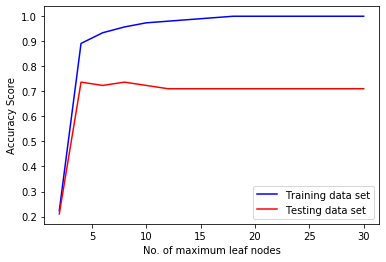

In [25]:
plt.plot(max_leaf_nodes1,acc_score_train1,'b-',max_leaf_nodes1,acc_score_val1,'r-')
plt.xlabel('No. of maximum leaf nodes')
plt.ylabel('Accuracy Score')
plt.legend(("Training data set","Testing data set",))
plt.show()

In [26]:
dt_GS1 = GridSearchCV(dt, param_grid={"max_leaf_nodes":[None,2,4,6,8,10,12,14,16,18,20,25,30]}, cv=5)
dt_GS1.fit(train_features_flatten, train_labels)
results1 = pd.DataFrame(dt_GS1.cv_results_)

In [27]:
print("Best parameters: ", dt_GS1.best_params_,'\n\n')
print(results1[['param_max_leaf_nodes','mean_test_score','rank_test_score']])

Best parameters:  {'max_leaf_nodes': 6} 


   param_max_leaf_nodes  mean_test_score  rank_test_score
0                  None         0.832240               12
1                     2         0.351639               13
2                     4         0.852077                4
3                     6         0.868525                1
4                     8         0.861913                2
5                    10         0.848689               11
6                    12         0.855246                3
7                    14         0.851967                5
8                    16         0.851967                5
9                    18         0.851967                5
10                   20         0.851967                5
11                   25         0.851967                5
12                   30         0.851967                5


In [28]:
#Using GridSearch1's best results to predict training dataset
train_labels_pred_GS = dt_GS.predict(train_features_flatten)
val_labels_pred_GS = dt_GS.predict(val_features_flatten)

In [44]:
#Classification Report & Accuracy Scores on Grid Search 1 training and testing data
print("\n\nClassification Matrix on Training Data:\n\n",classification_report(train_labels, train_labels_pred_GS))

print("\n\nAccuracy on Training Data: ", accuracy_score(train_labels, train_labels_pred_GS))

print("\n\nClassification Matrix on Testing Data:\n\n",classification_report(val_labels, val_labels_pred_GS))

print("\n\nAccuracy on Testing Data: ", accuracy_score(val_labels, val_labels_pred_GS))



Classification Matrix on Training Data:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00       112

   micro avg       1.00      1.00      1.00       304
   macro avg       1.00      1.00      1.00       304
weighted avg       1.00      1.00      1.00       304
 samples avg       1.00      1.00      1.00       304



Accuracy on Training Data:  1.0


Classification Matrix on Testing Data:

               precision    recall  f1-score   support

           0       0.69      0.86      0.76        28
           1       0.68      0.75      0.71        20
           2       0.79      0.54      0.64        28

   micro avg       0.71      0.71      0.71        76
   macro avg       0.72      0.71      0.70        76
weighted avg       0.72      0.71      0.70        76
 samples avg       0.71      0.71      0.71        76



Accurac

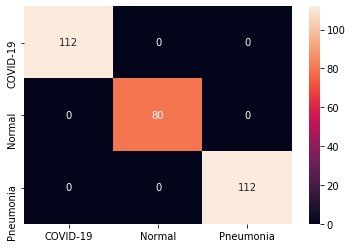

In [32]:
#Confusion matrix plot for GridSearch1's best results on training data set
#fig100 = plt.figure()
# fig100 = plt.figure(figsize=(10,10))
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(train_labels.argmax(axis=1), train_labels_pred_GS.argmax(axis=1))
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

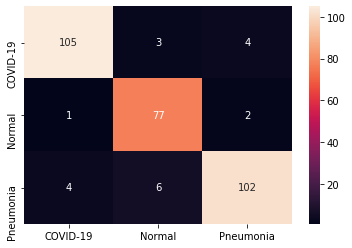

In [37]:
#Confusion matrix plot for GridSearch1's best results on testing data set
#fig100 = plt.figure()
# fig100 = plt.figure(figsize=(10,10))
categories = ['COVID-19','Normal','Pneumonia']
cm1 = confusion_matrix(val_labels.argmax(axis=1), val_labels_pred_GS.argmax(axis=1))
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

In [33]:
#Using GridSearch2's best results to predict testing dataset
train_labels_pred_GS1 = dt_GS1.predict(train_features_flatten)
val_labels_pred_GS1 = dt_GS1.predict(val_features_flatten)

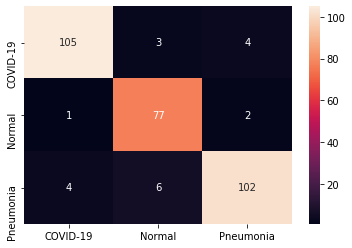

In [38]:
#Confusion matrix plot for GridSearch2's best results on training dataset
#fig100 = plt.figure()
# fig100 = plt.figure(figsize=(10,10))
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(train_labels.argmax(axis=1), train_labels_pred_GS1.argmax(axis=1))
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

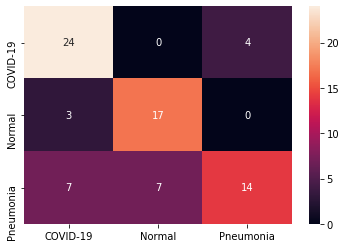

In [39]:
#Confusion matrix plot for GridSearch2's best results on testing dataset
#fig100 = plt.figure()
# fig100 = plt.figure(figsize=(10,10))
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(val_labels.argmax(axis=1), val_labels_pred_GS1.argmax(axis=1))
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

In [45]:
#Classification Report on Grid Search 2 training and testing data
print("\n\nClassification Matrix on Training Data:\n\n",classification_report(train_labels, train_labels_pred_GS1))

print("\n\nAccuracy on Training Data: ", accuracy_score(train_labels, train_labels_pred_GS1))

print("\n\nClassification Matrix on Testing Data:\n\n",classification_report(val_labels, val_labels_pred_GS1))

print("\n\nAccuracy on Testing Data: ", accuracy_score(val_labels, val_labels_pred_GS1))



Classification Matrix on Training Data:

               precision    recall  f1-score   support

           0       0.95      0.94      0.95       112
           1       0.90      0.96      0.93        80
           2       0.94      0.91      0.93       112

   micro avg       0.93      0.93      0.93       304
   macro avg       0.93      0.94      0.93       304
weighted avg       0.94      0.93      0.93       304
 samples avg       0.93      0.93      0.93       304



Accuracy on Training Data:  0.9342105263157895


Classification Matrix on Testing Data:

               precision    recall  f1-score   support

           0       0.71      0.86      0.77        28
           1       0.71      0.85      0.77        20
           2       0.78      0.50      0.61        28

   micro avg       0.72      0.72      0.72        76
   macro avg       0.73      0.74      0.72        76
weighted avg       0.73      0.72      0.71        76
 samples avg       0.72      0.72      0.72      